<a href="https://colab.research.google.com/github/ElAm1ne/Big-Data-Connected-Components/blob/main/Big_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors : Mbengue Kounda & El Hassani Amine 

---


### Big Data Project : CCF - Fast and Scalable Connected Component Computation in MapReduce

---



The GCC (Giant Connected Component) problem is a classical problem in graph theory that consists in finding the largest connected component of an undirected graph. In this project, we implemented two versions of the GCC algorithm using RDD (Resilient Distributed Datasets), which is a distributed data abstraction in Apache Spark. The two versions of the GCC algorithm that we implemented are the naive algorithm and the improved algorithm.


## Initialization

---

In this part we import the necessary libraries for the realization of our project. 

In [ ]:
!pip install pyspark
from pyspark import SparkConf
from pyspark.context import SparkContext
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 20.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=10868641a9a94e64bf9e100614d7ce71b3e8095238c49cbc99949c8a0b77a93f
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


We have also implemented functions to generate connected components to perform our tests and allow a better visualization.

In [ ]:
import networkx as nx
import random
from itertools import chain

def create_oriented_graph(n_components, n_elements):
    graphs = []
    current_node = 0

    for i in range(n_components):
        component_size = random.randint(2, n_elements)
        G = nx.DiGraph()
        G.add_nodes_from(range(current_node, current_node + component_size))

        for node in range(current_node, current_node + component_size - 1):
            G.add_edge(node, node + 1)

        graphs.append(G)
        current_node += component_size

    return nx.compose_all(graphs)


def save_graph_to_file(graph, file_path):
    with open(file_path, 'w') as f:
        for edge in graph.edges:
            f.write(f"{edge[0]},{edge[1]}\n")


def main():
    n_components = int(input("Enter the number of disjoint connected components: "))
    n_elements = int(input("Enter the number of disjoint connected elements: "))
    graph = create_oriented_graph(n_components, n_elements)
    file_path = "oriented_graph.txt"

    save_graph_to_file(graph, file_path)
    print(f"Oriented graph saved to {file_path}")


if __name__ == "__main__":
    main()


Enter the number of disjoint connected components: 5
Enter the number of disjoint connected elements: 10
Oriented graph saved to oriented_graph.txt


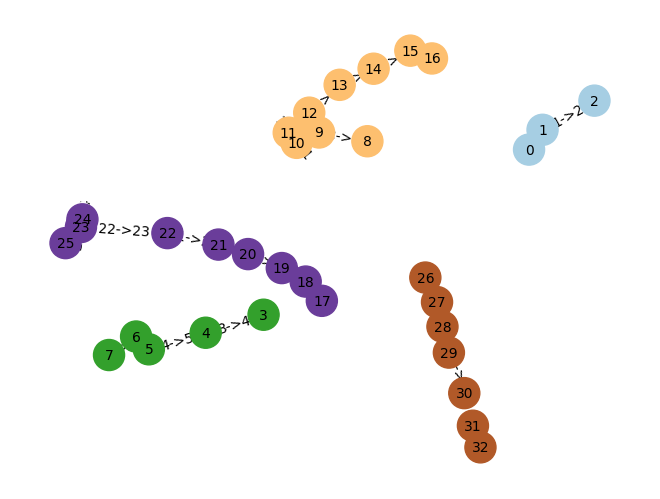

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import chain

def load_graph_from_file(file_path):
    G = nx.DiGraph()
    with open(file_path, 'r') as f:
        for line in f:
            start, end = map(int, line.strip().split(','))
            G.add_edge(start, end)
    return G

def plot_graph_with_colors(graph):
    components = list(nx.weakly_connected_components(graph))
    node_colors = []
    for node in graph.nodes:
        for i, component in enumerate(components):
            if node in component:
                node_colors.append(i)
                break
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, node_color=node_colors, cmap=plt.cm.Paired, with_labels=True, node_size=500, font_size=10)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels={(u, v): f"{u}->{v}" for u, v in graph.edges()}, font_size=10)
    plt.axis("off")
    plt.show()

def main():
    file_path = "oriented_graph.txt"
    graph = load_graph_from_file(file_path)
    plot_graph_with_colors(graph)

if __name__ == "__main__":
    main()


In this part we import a graph file with more than 2 millions edges to measure the performance of the developed solution. 

In [ ]:
with open('oriented_graph.txt', 'r') as f:
    lines = f.readlines()

edge_list = [(int(line.strip().split(',')[0]), int(line.strip().split(',')[1])) for line in lines]

g = sc.parallelize(edge_list)



### I) Algorithms implementation.

### 1) CCF Iterate without sorting 

In [ ]:
def CCF_Iterate(graph):
  # Create a complete adjacency list by mapping each edge (u,v) to (u,v) and (v,u)
  complete_adjacency_list = graph.flatMap(lambda x: [(x[0],x[1]), (x[1], x[0])])
  # Group values associated with each key to obtain the adjacency list of each node
  node_adjacency_lists = complete_adjacency_list.groupByKey().map(lambda x: (x[0], list(x[1])))
  # Determine the minimum in the adjacency list of each node and store it along with the adjacency list
  node_min_adjacency = node_adjacency_lists.map(lambda x: (x[0], x[1], min(x[1])))
  # Filter nodes that have an identifier greater than or equal to their minimum
  filtered_node_min_adjacency = node_min_adjacency.filter(lambda x: x[2]<x[0])
  # Count the number of iterations needed to connect all nodes in the graph
  num_iterations_remaining = filtered_node_min_adjacency.map(lambda x: len([l for l in x[1] if l!= x[2]])).sum()
  # Create pairs of nodes that need to be connected
  node_pairs_to_connect = filtered_node_min_adjacency.flatMap(lambda x: [(i,x[2]) for i in x[1]+list([x[0]]) if i!=x[2]] )
  # Remove duplicate node pairs
  unique_node_pairs_to_connect = node_pairs_to_connect.distinct()
  # Return the updated adjacency list and the number of remaining iterations
  return unique_node_pairs_to_connect, num_iterations_remaining


def run_CCF_Iterate(graph): 
  created_couples = 1
  i = 1
  while created_couples > 0:  
    #Number of iteration 
    print("Iteration number : "+str(i))
    # Repeat the algorithm until all nodes are connected
    graph, created_couples = CCF_Iterate(graph)
    print("Number of pairs created : "+str(created_couples))
    i+=1
  # Sort connected components in ascending order of their first value (node identifier)
  sorted_connected_components = sorted(graph.collect(), key=lambda x: x[1])
  #number of connected components 
  count_connected_components = graph.map(lambda x : x[1]).distinct().count()
  print("Number of connected components found is : " +str(count_connected_components))
  return sorted_connected_components, count_connected_components

In [ ]:
sorted_connected_components, count_connected_components = run_CCF_Iterate(g)

Iteration number : 1
Number of pairs created : 23
Iteration number : 2
Number of pairs created : 64
Iteration number : 3
Number of pairs created : 110
Iteration number : 4
Number of pairs created : 94
Iteration number : 5
Number of pairs created : 0
Number of connected components found is : 5


### 2) CCF Iterate with sorting 

In [ ]:
# Obtain the connected components of the graph using the sorted algorithm
def CCF_Iterate_sorted(graph):
  # Create complete adjacency list by mapping each edge (u,v) to (u,v) and (v,u)
  complete_adjacency_list = graph.flatMap(lambda x: [(x[0],x[1]), (x[1], x[0])])
  # Group values associated with each key to obtain the adjacency list of each node, sorted in ascending order
  node_adjacency_lists = complete_adjacency_list.groupByKey().map(lambda x: (x[0], sorted(list(x[1]))))
  # Determine the minimum in the adjacency list of each node and store it along with the adjacency list
  node_min_adjacency = node_adjacency_lists.map(lambda x: (x[0], x[1], x[1][0]))
  # Filter nodes that have an identifier greater than or equal to their minimum
  filtered_node_min_adjacency = node_min_adjacency.filter(lambda x: x[2]<x[0])
  # Count the number of iterations needed to connect all nodes in the graph
  num_iterations_remaining = filtered_node_min_adjacency.map(lambda x: len([l for l in x[1] if l!= x[2]])).sum()
  # Create pairs of nodes that need to be connected
  node_pairs_to_connect = filtered_node_min_adjacency.flatMap(lambda x: [(i,x[2]) for i in x[1]+list([x[0]]) if i!=x[2]] )
  # Remove duplicate node pairs
  unique_node_pairs_to_connect = node_pairs_to_connect.distinct()
  # Return the updated adjacency list and the number of remaining iterations
  return unique_node_pairs_to_connect, num_iterations_remaining

# Function to obtain the connected components of a graph using the sorted algorithm
def run_CCF_Iterate_Sorted(graph): 
  created_couples = 1
  i = 1
  while created_couples > 0: 
    #Number of iteration 
    print("Iteration number : "+str(i))
    # Repeat the algorithm until all nodes are connected
    graph, created_couples = CCF_Iterate_sorted(graph)
    print("Number of pairs created : "+str(created_couples))
    i+=1
  # Sort connected components in ascending order of their first value (node identifier)
  sorted_connected_components = sorted(graph.collect(), key=lambda x: x[1])
  #number of connected components 
  count_connected_components = graph.map(lambda x : x[1]).distinct().count()
  print("Number of connected components found is : " +str(count_connected_components))
  return sorted_connected_components, count_connected_components

In [ ]:
# Obtain the connected components of the graph and return the result
graph,count_connected_components = run_CCF_Iterate_Sorted(g)

Iteration number : 1
Number of pairs created : 23
Iteration number : 2
Number of pairs created : 64
Iteration number : 3
Number of pairs created : 110
Iteration number : 4
Number of pairs created : 94
Iteration number : 5
Number of pairs created : 0
Number of connected components found is : 5


Here we import google graph to run our algorithms. We have more than 875K nodes, 5M edges in this graph. 

 
---

The goal is to benchmark the time needed to find to all connected components using both approaches (sorted and unsorted)

We will use the built-in  %%timeit  magic command. 

---



In [ ]:
google_graph = sc.textFile("/content/web-Google.txt")
google_graph = google_graph.filter(lambda x: "#" not in x).map(lambda x: x.split("\t")).map(lambda x: (x[0], x[1]))
google_graph = google_graph.partitionBy(100).persist()

In [ ]:
%%timeit -n 1 -r 1
sorted_connected_components, count_connected_components = run_CCF_Iterate(google_graph)

Iteration number : 1
Number of pairs created : 8546673
Iteration number : 2
Number of pairs created : 4774134
Iteration number : 3
Number of pairs created : 3235857
Iteration number : 4
Number of pairs created : 3852842
Iteration number : 5
Number of pairs created : 2014247
Iteration number : 6
Number of pairs created : 94614
Iteration number : 7
Number of pairs created : 1548
Iteration number : 8
Number of pairs created : 0
Number of connected components found is : 2746
8min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Benchmarking with sorting algorithm

In [ ]:
%%timeit -n 1 -r 1
graph,count_connected_components = run_CCF_Iterate_Sorted(google_graph)

Iteration number : 1
Number of pairs created : 8546673
Iteration number : 2
Number of pairs created : 4774134
Iteration number : 3
Number of pairs created : 3235857
Iteration number : 4
Number of pairs created : 3852842
Iteration number : 5
Number of pairs created : 2014247
Iteration number : 6
Number of pairs created : 94614
Iteration number : 7
Number of pairs created : 1548
Iteration number : 8
Number of pairs created : 0
Number of connected components found is : 2746
7min 38s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


We see a better performance with the version in which a sorting is done. An improvement of +7%.


---



The goal of this part is to analyze the temporal complexity of both algorithms (sorted and unsorted). There are two parameters to take into account, firstly the number of components and secondly the number of elements in each components. 

In [ ]:
import time
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.interpolate import griddata
import plotly.graph_objects as go

We will start by simulating multiple graphs, with number of component ranging from 10 to 1000 and number of elements ranging from  5 to 100. 

In [ ]:
#create a list of graphes with different number of components and elements to study the complexity of the algorithm depending on the these two parameters
graphs = [[(u,v) for u,v in create_oriented_graph(n_comp, n_elm).edges] for n_comp in range(10,1000,100) for n_elm in range(5,100,20)]
indexes = [(i,j) for i in range(10,1000,100) for j in range(5,100,20)]

This funtions take as argument the list of graph defined previously, and a parameter to specificy which algorithms to use. Then, we time the execution and store it in array for later use. 

In [ ]:
def benchmark(graphs,version="unsorted"):
  X = np.zeros(len(graphs))
  Y = np.zeros(len(graphs))
  Z = np.zeros(len(graphs))
  for i in range(len(graphs)):
    graph = sc.parallelize(graphs[i])
    print("N° Components : " + str(indexes[i][0]) + ", N° elements : " + str(indexes[i][1]))
    start_time = time.time()
    if(version=="unsorted"):
      run_CCF_Iterate(graph)
    else: 
      run_CCF_Iterate_Sorted(graph)
    end_time = time.time()
    X[i] = indexes[i][0]
    Y[i] = indexes[i][1]
    Z[i] = end_time - start_time
    print("It took : " + str(end_time - start_time) + " s.")
  return X,Y,Z

In [ ]:
X,Y,Z = benchmark(graphs)

We convert the stored number of components in X, number of elements in Y and the time in Z to pandas dataframe for further analysis.  

In [ ]:
df = pd.DataFrame({'N_Components': X, 'N_Elements': Y, 'Time': Z})

In [ ]:
df

,N_Components,N_Elements,Time
0,10.0,5.0,1.293401
1,10.0,25.0,1.795485
2,10.0,45.0,2.174206
3,10.0,65.0,2.032078
4,10.0,85.0,2.310068
5,110.0,5.0,1.084860
6,110.0,25.0,2.406908
7,110.0,45.0,2.593492
8,110.0,65.0,2.826719
9,110.0,85.0,4.371413


Analyze the results using a pair plot, we see that execution time varies exponentially with the number of elements and linearly with the number of components.

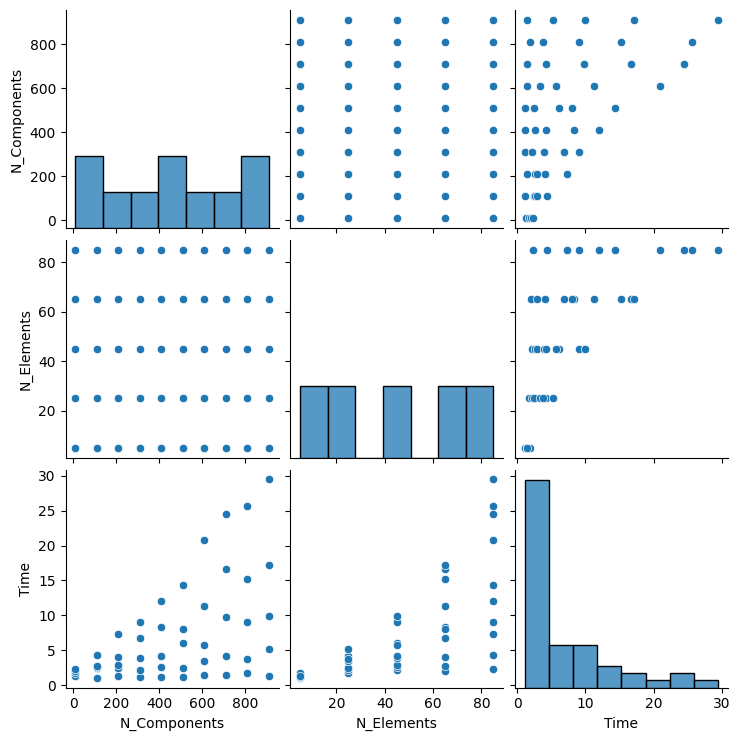

In [ ]:
sns.pairplot(df)

Create a mesh to plot the surface representing the execution time as a function of the number of elements and the number of components

In [ ]:
xi = np.linspace(X.min(), X.max(), 100)
yi = np.linspace(X.min(), X.max(), 100)
x,y = np.meshgrid(xi,yi)
z = griddata((X,Y),Z,(x,y), method='cubic')

We plot a 3D surface representing the temporal complexity depending on both parameters (number of components, number of elements). We can clearly see the exponential pattern. Especially for higher number of elements.

In [ ]:
fig = go.Figure(go.Surface(x=xi,y=yi,z=z, hidesurface = False))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_z=True), 
                  contours_x=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_x=True),
                  contours_y=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_y=True))
fig.update_layout(title='Execution time % N Components & N elements', autosize=True,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=0.64),
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [ ]:
X,Y,Z = benchmark(graphs,"sorted")

In [ ]:
df = pd.DataFrame({'N_Components': X, 'N_Elements': Y, 'Time': Z})

In [ ]:
df

,N_Components,N_Elements,Time
0,10.0,5.0,1.117019
1,10.0,25.0,1.922019
2,10.0,45.0,2.195843
3,10.0,65.0,2.597134
4,10.0,85.0,2.678453
5,110.0,5.0,1.205941
6,110.0,25.0,1.878044
7,110.0,45.0,2.428778
8,110.0,65.0,3.225211
9,110.0,85.0,5.643924


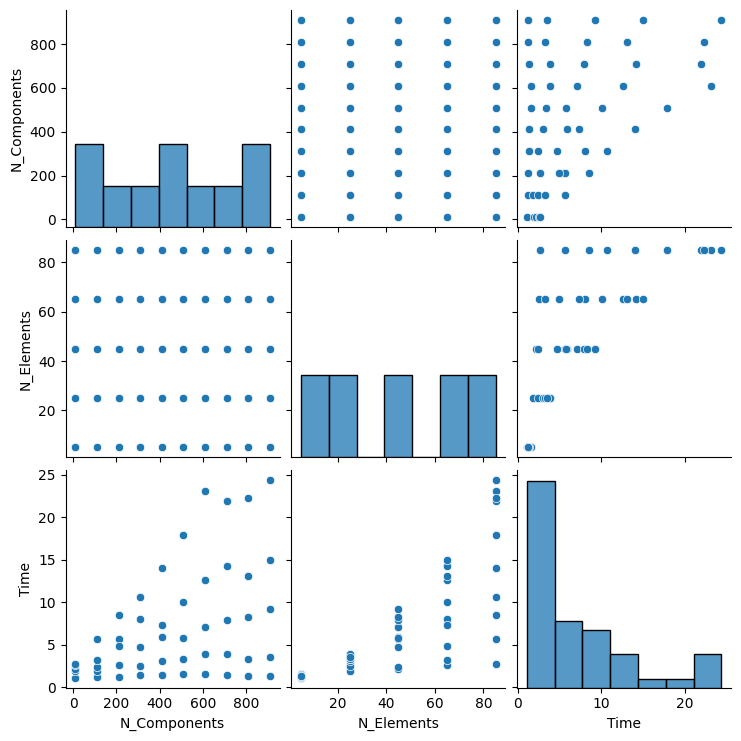

In [ ]:
sns.pairplot(df)

In [ ]:
xi = np.linspace(X.min(), X.max(), 100)
yi = np.linspace(X.min(), X.max(), 100)
x,y = np.meshgrid(xi,yi)
z = griddata((X,Y),Z,(x,y), method='cubic')

In [ ]:
fig = go.Figure(go.Surface(x=xi,y=yi,z=z, hidesurface = False))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_z=True), 
                  contours_x=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_x=True),
                  contours_y=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_y=True))
fig.update_layout(title='Execution time % N Components & N elements', autosize=True,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=0.64),
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()